<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:55:21] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


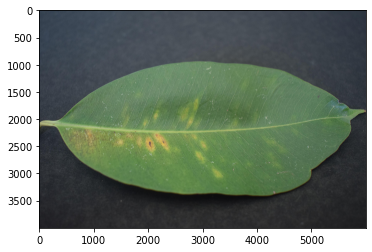

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

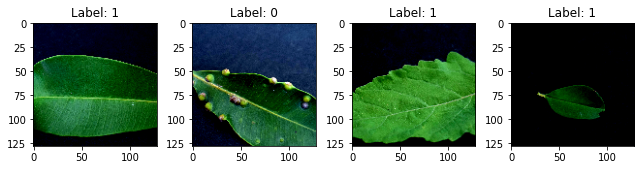

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:55:26] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:55:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2582979318939356 samples/sec                   batch loss = 0.5429468750953674 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2618888450973726 samples/sec                   batch loss = 0.8973037004470825 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2345812522379578 samples/sec                   batch loss = 0.6729649901390076 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2683483462506338 samples/sec                   batch loss = 0.24322456121444702 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2650958024198709 samples/sec                   batch loss = 0.6064870953559875 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2626124912513077 samples/sec                   batch loss = 0.5046557784080505 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2619577551597287 samples/sec                   batch loss = 0.7847627401351929 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2703994085226142 samples/sec                   batch loss = 0.6599386930465698 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2730434824837178 samples/sec                   batch loss = 1.0682123899459839 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.273051500139505 samples/sec                   batch loss = 0.8315755128860474 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2734813169860424 samples/sec                   batch loss = 0.5865331292152405 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.2710058339606083 samples/sec                   batch loss = 0.6276264786720276 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2689095301162274 samples/sec                   batch loss = 1.0339149236679077 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2717244572348836 samples/sec                   batch loss = 0.75660240650177 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.265975576803026 samples/sec                   batch loss = 0.5024022459983826 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.2745611967243964 samples/sec                   batch loss = 0.8069198727607727 | accuracy = 0.615625


Epoch[1] Batch[85] Speed: 1.2634893848526918 samples/sec                   batch loss = 0.5225642323493958 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2640617048858893 samples/sec                   batch loss = 0.615393340587616 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.266145257299184 samples/sec                   batch loss = 0.6255931258201599 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2602710543195597 samples/sec                   batch loss = 0.5893497467041016 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.2703175503123167 samples/sec                   batch loss = 0.30969858169555664 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2626532566393807 samples/sec                   batch loss = 0.6127089858055115 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2627046684925485 samples/sec                   batch loss = 0.2591746747493744 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2647323554128822 samples/sec                   batch loss = 0.6370643973350525 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.2626712170512684 samples/sec                   batch loss = 0.7332682609558105 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.2703364989243886 samples/sec                   batch loss = 0.4791703522205353 | accuracy = 0.6173076923076923


Epoch[1] Batch[135] Speed: 1.2707146274662147 samples/sec                   batch loss = 0.39949339628219604 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.268251604211415 samples/sec                   batch loss = 0.32351818680763245 | accuracy = 0.625


Epoch[1] Batch[145] Speed: 1.269009060170844 samples/sec                   batch loss = 2.16630482673645 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2719316493944357 samples/sec                   batch loss = 0.7056482434272766 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.26734137984407 samples/sec                   batch loss = 1.2778640985488892 | accuracy = 0.617741935483871


Epoch[1] Batch[160] Speed: 1.266845192106139 samples/sec                   batch loss = 0.7476277351379395 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2685530009319137 samples/sec                   batch loss = 0.5476141571998596 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2673903019337027 samples/sec                   batch loss = 0.6376045942306519 | accuracy = 0.6235294117647059


Epoch[1] Batch[175] Speed: 1.2613900885653306 samples/sec                   batch loss = 0.6367425918579102 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.2671864050481965 samples/sec                   batch loss = 0.6565483212471008 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2652223092238322 samples/sec                   batch loss = 0.6140314936637878 | accuracy = 0.6283783783783784


Epoch[1] Batch[190] Speed: 1.2639252415586408 samples/sec                   batch loss = 0.7966061234474182 | accuracy = 0.6276315789473684


Epoch[1] Batch[195] Speed: 1.2660294568971835 samples/sec                   batch loss = 0.8931766748428345 | accuracy = 0.6307692307692307


Epoch[1] Batch[200] Speed: 1.2673234777924003 samples/sec                   batch loss = 0.3933812081813812 | accuracy = 0.63375


Epoch[1] Batch[205] Speed: 1.264274029167678 samples/sec                   batch loss = 0.4104279577732086 | accuracy = 0.6378048780487805


Epoch[1] Batch[210] Speed: 1.2749637414768247 samples/sec                   batch loss = 0.1847948580980301 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.2695199132043051 samples/sec                   batch loss = 0.40014299750328064 | accuracy = 0.6406976744186047


Epoch[1] Batch[220] Speed: 1.2654745396770226 samples/sec                   batch loss = 0.49149957299232483 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2644629805850869 samples/sec                   batch loss = 0.508562445640564 | accuracy = 0.6444444444444445


Epoch[1] Batch[230] Speed: 1.2643024206818132 samples/sec                   batch loss = 0.36772510409355164 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2680343000487118 samples/sec                   batch loss = 0.5784137845039368 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.261501057904311 samples/sec                   batch loss = 0.23929719626903534 | accuracy = 0.6541666666666667


Epoch[1] Batch[245] Speed: 1.2655257997010056 samples/sec                   batch loss = 1.807732105255127 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.2640763719237462 samples/sec                   batch loss = 0.37811198830604553 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2671788439371934 samples/sec                   batch loss = 0.37279510498046875 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2638083236416495 samples/sec                   batch loss = 0.3527432084083557 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2686486377760997 samples/sec                   batch loss = 0.29764023423194885 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.268330895158534 samples/sec                   batch loss = 0.6735044121742249 | accuracy = 0.6611111111111111


Epoch[1] Batch[275] Speed: 1.261594401080489 samples/sec                   batch loss = 0.4577080011367798 | accuracy = 0.6636363636363637


Epoch[1] Batch[280] Speed: 1.2625524407427509 samples/sec                   batch loss = 1.3606053590774536 | accuracy = 0.6633928571428571


Epoch[1] Batch[285] Speed: 1.261073506477341 samples/sec                   batch loss = 0.946381688117981 | accuracy = 0.6640350877192982


Epoch[1] Batch[290] Speed: 1.2628931510701709 samples/sec                   batch loss = 0.5281187295913696 | accuracy = 0.6637931034482759


Epoch[1] Batch[295] Speed: 1.268299446051249 samples/sec                   batch loss = 0.6762425303459167 | accuracy = 0.6627118644067796


Epoch[1] Batch[300] Speed: 1.2684735863075267 samples/sec                   batch loss = 0.5707399249076843 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2719262493934984 samples/sec                   batch loss = 0.29047510027885437 | accuracy = 0.6647540983606557


Epoch[1] Batch[310] Speed: 1.26895665377935 samples/sec                   batch loss = 0.23943910002708435 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.2658989679702333 samples/sec                   batch loss = 0.742332935333252 | accuracy = 0.6674603174603174


Epoch[1] Batch[320] Speed: 1.2669357879416783 samples/sec                   batch loss = 0.5478876829147339 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2649792401159359 samples/sec                   batch loss = 0.21821923553943634 | accuracy = 0.6707692307692308


Epoch[1] Batch[330] Speed: 1.266699041558247 samples/sec                   batch loss = 0.544495165348053 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2637366411868742 samples/sec                   batch loss = 0.6790937781333923 | accuracy = 0.6716417910447762


Epoch[1] Batch[340] Speed: 1.2714850507128583 samples/sec                   batch loss = 0.8193906545639038 | accuracy = 0.6705882352941176


Epoch[1] Batch[345] Speed: 1.270052617518476 samples/sec                   batch loss = 0.5683643817901611 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.2700213713904362 samples/sec                   batch loss = 0.9497169256210327 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.2644222888469472 samples/sec                   batch loss = 0.862134575843811 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.272555078997218 samples/sec                   batch loss = 0.4157964885234833 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2681055123973726 samples/sec                   batch loss = 0.7190264463424683 | accuracy = 0.6712328767123288


Epoch[1] Batch[370] Speed: 1.2676981860822782 samples/sec                   batch loss = 0.3088846802711487 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.2699208173652263 samples/sec                   batch loss = 0.36676543951034546 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.2714875561114247 samples/sec                   batch loss = 0.78537517786026 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.2757874447006836 samples/sec                   batch loss = 0.4843173325061798 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.2707878737933087 samples/sec                   batch loss = 0.8240846395492554 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.2728226985435975 samples/sec                   batch loss = 0.5915945172309875 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.270280808929118 samples/sec                   batch loss = 1.2329764366149902 | accuracy = 0.67375


Epoch[1] Batch[405] Speed: 1.2701600197808391 samples/sec                   batch loss = 0.18923664093017578 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2691605447372387 samples/sec                   batch loss = 0.8317297101020813 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2697519493510439 samples/sec                   batch loss = 0.19057013094425201 | accuracy = 0.6783132530120481


Epoch[1] Batch[420] Speed: 1.2676818065181445 samples/sec                   batch loss = 0.6416893005371094 | accuracy = 0.6791666666666667


Epoch[1] Batch[425] Speed: 1.2751566772445722 samples/sec                   batch loss = 0.8426204323768616 | accuracy = 0.6794117647058824


Epoch[1] Batch[430] Speed: 1.2745589696815824 samples/sec                   batch loss = 0.3930257558822632 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2703321705114095 samples/sec                   batch loss = 0.530198335647583 | accuracy = 0.6793103448275862


Epoch[1] Batch[440] Speed: 1.2695311527522866 samples/sec                   batch loss = 0.4874948263168335 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.2681941795950584 samples/sec                   batch loss = 0.18880237638950348 | accuracy = 0.6831460674157304


Epoch[1] Batch[450] Speed: 1.2678825093034414 samples/sec                   batch loss = 0.9811365604400635 | accuracy = 0.6838888888888889


Epoch[1] Batch[455] Speed: 1.2693595071586203 samples/sec                   batch loss = 0.3122471272945404 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2640566572178198 samples/sec                   batch loss = 0.8656365871429443 | accuracy = 0.6853260869565218


Epoch[1] Batch[465] Speed: 1.2674067697097837 samples/sec                   batch loss = 0.42927855253219604 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.263712272908322 samples/sec                   batch loss = 0.6263532042503357 | accuracy = 0.6872340425531915


Epoch[1] Batch[475] Speed: 1.2680562475511419 samples/sec                   batch loss = 0.6791460514068604 | accuracy = 0.6878947368421052


Epoch[1] Batch[480] Speed: 1.267043046434638 samples/sec                   batch loss = 0.7580307126045227 | accuracy = 0.6875


Epoch[1] Batch[485] Speed: 1.2678345072950366 samples/sec                   batch loss = 0.5199592113494873 | accuracy = 0.6881443298969072


Epoch[1] Batch[490] Speed: 1.267931856474108 samples/sec                   batch loss = 0.7315601110458374 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.2627758537363556 samples/sec                   batch loss = 0.38739213347435 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.2610425110244905 samples/sec                   batch loss = 0.7100831866264343 | accuracy = 0.6885


Epoch[1] Batch[505] Speed: 1.2640974206701867 samples/sec                   batch loss = 0.3798501193523407 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2651877701648628 samples/sec                   batch loss = 0.37936440110206604 | accuracy = 0.6887254901960784


Epoch[1] Batch[515] Speed: 1.2626938345930756 samples/sec                   batch loss = 0.4205825626850128 | accuracy = 0.6893203883495146


Epoch[1] Batch[520] Speed: 1.2675320154051095 samples/sec                   batch loss = 0.49381786584854126 | accuracy = 0.6889423076923077


Epoch[1] Batch[525] Speed: 1.260951429230247 samples/sec                   batch loss = 0.45943763852119446 | accuracy = 0.689047619047619


Epoch[1] Batch[530] Speed: 1.2627163579083809 samples/sec                   batch loss = 0.17120015621185303 | accuracy = 0.6900943396226416


Epoch[1] Batch[535] Speed: 1.2628220476542273 samples/sec                   batch loss = 0.4166538715362549 | accuracy = 0.6901869158878504


Epoch[1] Batch[540] Speed: 1.2606071243785522 samples/sec                   batch loss = 0.45854082703590393 | accuracy = 0.6916666666666667


Epoch[1] Batch[545] Speed: 1.2726884885264556 samples/sec                   batch loss = 0.5132440328598022 | accuracy = 0.6922018348623853


Epoch[1] Batch[550] Speed: 1.2689751778883336 samples/sec                   batch loss = 0.6905893683433533 | accuracy = 0.6918181818181818


Epoch[1] Batch[555] Speed: 1.2723492275717871 samples/sec                   batch loss = 0.3414125442504883 | accuracy = 0.6923423423423424


Epoch[1] Batch[560] Speed: 1.2734136557036502 samples/sec                   batch loss = 0.48419785499572754 | accuracy = 0.6915178571428572


Epoch[1] Batch[565] Speed: 1.2728153597104237 samples/sec                   batch loss = 0.27499890327453613 | accuracy = 0.6920353982300885


Epoch[1] Batch[570] Speed: 1.262684806485527 samples/sec                   batch loss = 0.4225485622882843 | accuracy = 0.6929824561403509


Epoch[1] Batch[575] Speed: 1.265888747792061 samples/sec                   batch loss = 0.6055470108985901 | accuracy = 0.6939130434782609


Epoch[1] Batch[580] Speed: 1.268412018043471 samples/sec                   batch loss = 0.12302906066179276 | accuracy = 0.6948275862068966


Epoch[1] Batch[585] Speed: 1.269994741288741 samples/sec                   batch loss = 0.2893192768096924 | accuracy = 0.6935897435897436


Epoch[1] Batch[590] Speed: 1.2688079046387843 samples/sec                   batch loss = 0.3343992233276367 | accuracy = 0.6953389830508474


Epoch[1] Batch[595] Speed: 1.2659714691116597 samples/sec                   batch loss = 0.582267701625824 | accuracy = 0.6953781512605042


Epoch[1] Batch[600] Speed: 1.2661555771748378 samples/sec                   batch loss = 0.7753111720085144 | accuracy = 0.695


Epoch[1] Batch[605] Speed: 1.2653077108489708 samples/sec                   batch loss = 0.41368478536605835 | accuracy = 0.6958677685950413


Epoch[1] Batch[610] Speed: 1.2683851677128044 samples/sec                   batch loss = 1.3379361629486084 | accuracy = 0.6959016393442623


Epoch[1] Batch[615] Speed: 1.264149140703104 samples/sec                   batch loss = 0.8113032579421997 | accuracy = 0.6963414634146341


Epoch[1] Batch[620] Speed: 1.2641179938780316 samples/sec                   batch loss = 0.1911391168832779 | accuracy = 0.6971774193548387


Epoch[1] Batch[625] Speed: 1.2648880655951031 samples/sec                   batch loss = 0.5771911144256592 | accuracy = 0.6968


Epoch[1] Batch[630] Speed: 1.2679150875871903 samples/sec                   batch loss = 0.869707465171814 | accuracy = 0.6964285714285714


Epoch[1] Batch[635] Speed: 1.2670913713147711 samples/sec                   batch loss = 0.563650906085968 | accuracy = 0.6964566929133859


Epoch[1] Batch[640] Speed: 1.264390842693551 samples/sec                   batch loss = 0.7019299268722534 | accuracy = 0.69765625


Epoch[1] Batch[645] Speed: 1.270713183799551 samples/sec                   batch loss = 0.3222543001174927 | accuracy = 0.6988372093023256


Epoch[1] Batch[650] Speed: 1.2716271031279562 samples/sec                   batch loss = 0.6694008708000183 | accuracy = 0.698076923076923


Epoch[1] Batch[655] Speed: 1.26714142255167 samples/sec                   batch loss = 0.6556387543678284 | accuracy = 0.6988549618320611


Epoch[1] Batch[660] Speed: 1.2732057872328024 samples/sec                   batch loss = 0.4557453691959381 | accuracy = 0.6992424242424242


Epoch[1] Batch[665] Speed: 1.2687557067559672 samples/sec                   batch loss = 0.6750996112823486 | accuracy = 0.6981203007518797


Epoch[1] Batch[670] Speed: 1.272056537207497 samples/sec                   batch loss = 0.408983439207077 | accuracy = 0.6988805970149253


Epoch[1] Batch[675] Speed: 1.2727021978920614 samples/sec                   batch loss = 0.1529652327299118 | accuracy = 0.6988888888888889


Epoch[1] Batch[680] Speed: 1.2736915961427009 samples/sec                   batch loss = 0.297341912984848 | accuracy = 0.7


Epoch[1] Batch[685] Speed: 1.2712245431602718 samples/sec                   batch loss = 0.6496105194091797 | accuracy = 0.7


Epoch[1] Batch[690] Speed: 1.2745778513782502 samples/sec                   batch loss = 0.5272818207740784 | accuracy = 0.6996376811594203


Epoch[1] Batch[695] Speed: 1.2677724262556165 samples/sec                   batch loss = 1.5465716123580933 | accuracy = 0.6985611510791367


Epoch[1] Batch[700] Speed: 1.2730829921504216 samples/sec                   batch loss = 1.1683111190795898 | accuracy = 0.6982142857142857


Epoch[1] Batch[705] Speed: 1.274728731386575 samples/sec                   batch loss = 1.204619288444519 | accuracy = 0.698936170212766


Epoch[1] Batch[710] Speed: 1.2722694334246214 samples/sec                   batch loss = 0.664595901966095 | accuracy = 0.6992957746478873


Epoch[1] Batch[715] Speed: 1.2668694900343953 samples/sec                   batch loss = 0.5349567532539368 | accuracy = 0.6996503496503497


Epoch[1] Batch[720] Speed: 1.2699213941115524 samples/sec                   batch loss = 0.794781506061554 | accuracy = 0.6996527777777778


Epoch[1] Batch[725] Speed: 1.268410291916595 samples/sec                   batch loss = 0.5389328598976135 | accuracy = 0.7


Epoch[1] Batch[730] Speed: 1.2669227765497026 samples/sec                   batch loss = 0.6550872325897217 | accuracy = 0.6993150684931507


Epoch[1] Batch[735] Speed: 1.266905268995481 samples/sec                   batch loss = 0.37650737166404724 | accuracy = 0.7


Epoch[1] Batch[740] Speed: 1.2706224318735286 samples/sec                   batch loss = 0.10987486690282822 | accuracy = 0.7003378378378379


Epoch[1] Batch[745] Speed: 1.2723461398249225 samples/sec                   batch loss = 0.3980407118797302 | accuracy = 0.7013422818791947


Epoch[1] Batch[750] Speed: 1.2749479487182216 samples/sec                   batch loss = 0.7554365992546082 | accuracy = 0.7003333333333334


Epoch[1] Batch[755] Speed: 1.2639632350171395 samples/sec                   batch loss = 0.5628942251205444 | accuracy = 0.7


Epoch[1] Batch[760] Speed: 1.2646420744174651 samples/sec                   batch loss = 0.4389408826828003 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.269601476493378 samples/sec                   batch loss = 0.443111389875412 | accuracy = 0.6977124183006536


Epoch[1] Batch[770] Speed: 1.269463718449481 samples/sec                   batch loss = 0.45765143632888794 | accuracy = 0.6977272727272728


Epoch[1] Batch[775] Speed: 1.2738001950498046 samples/sec                   batch loss = 0.2030034065246582 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.2667837818124599 samples/sec                   batch loss = 0.6261283159255981 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.2676102586482478 samples/sec                   batch loss = 0.3132394850254059 | accuracy = 0.7003184713375796


[Epoch 1] training: accuracy=0.700507614213198
[Epoch 1] time cost: 657.4212126731873
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2615468740177778 samples/sec                   batch loss = 0.18067719042301178 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.268551178504183 samples/sec                   batch loss = 0.3826935291290283 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.270424420185593 samples/sec                   batch loss = 0.5359941124916077 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2713865770981037 samples/sec                   batch loss = 0.6186959743499756 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2727092457794684 samples/sec                   batch loss = 0.5805060267448425 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2716902370132666 samples/sec                   batch loss = 0.27714863419532776 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2647866064765558 samples/sec                   batch loss = 0.5124469995498657 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2644114254534793 samples/sec                   batch loss = 0.5508282780647278 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2633597043820028 samples/sec                   batch loss = 0.3983345627784729 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2702253161572594 samples/sec                   batch loss = 1.5296363830566406 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2777806126839932 samples/sec                   batch loss = 0.6325053572654724 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2702952359204005 samples/sec                   batch loss = 0.42602455615997314 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2694608368012843 samples/sec                   batch loss = 0.3280690908432007 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2706844073950956 samples/sec                   batch loss = 0.5837492346763611 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2718831474582337 samples/sec                   batch loss = 0.1680033653974533 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2716753927574633 samples/sec                   batch loss = 0.9554905295372009 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2684916167748428 samples/sec                   batch loss = 0.8153979778289795 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.2697682863540758 samples/sec                   batch loss = 0.44612643122673035 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2729851401745205 samples/sec                   batch loss = 0.5260254740715027 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.272399791558767 samples/sec                   batch loss = 0.20766106247901917 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.281454189270875 samples/sec                   batch loss = 0.5347028970718384 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.2620122430987768 samples/sec                   batch loss = 1.0457711219787598 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2625602317837188 samples/sec                   batch loss = 0.7825651168823242 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2712344643842983 samples/sec                   batch loss = 0.5076860189437866 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2754928796224523 samples/sec                   batch loss = 0.4756268262863159 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2716117784433163 samples/sec                   batch loss = 0.21298828721046448 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.2699739763526123 samples/sec                   batch loss = 0.6149618029594421 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2701897340888204 samples/sec                   batch loss = 0.35885801911354065 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.271274247158386 samples/sec                   batch loss = 0.47019433975219727 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.2620349319730781 samples/sec                   batch loss = 0.692578911781311 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2710892254206088 samples/sec                   batch loss = 0.6445840001106262 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2681866064528302 samples/sec                   batch loss = 0.5298289060592651 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2739412175234406 samples/sec                   batch loss = 0.28854867815971375 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2737883962309346 samples/sec                   batch loss = 0.47012925148010254 | accuracy = 0.7529411764705882


Epoch[2] Batch[175] Speed: 1.2733522834736986 samples/sec                   batch loss = 0.380339652299881 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.2761281536548958 samples/sec                   batch loss = 0.7105923891067505 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2727406243077661 samples/sec                   batch loss = 0.22947204113006592 | accuracy = 0.7567567567567568


Epoch[2] Batch[190] Speed: 1.2699200483709399 samples/sec                   batch loss = 0.5585786700248718 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2657233375797678 samples/sec                   batch loss = 0.7783828377723694 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2753053677373256 samples/sec                   batch loss = 0.11952202022075653 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2666165120063537 samples/sec                   batch loss = 0.3630578815937042 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.269428467185428 samples/sec                   batch loss = 0.6976762413978577 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.2689147125881268 samples/sec                   batch loss = 0.5104878544807434 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2718992500765691 samples/sec                   batch loss = 0.3916199207305908 | accuracy = 0.7431818181818182


Epoch[2] Batch[225] Speed: 1.269027297842477 samples/sec                   batch loss = 0.5082228183746338 | accuracy = 0.7422222222222222


Epoch[2] Batch[230] Speed: 1.2735352578444914 samples/sec                   batch loss = 0.4081847369670868 | accuracy = 0.7423913043478261


Epoch[2] Batch[235] Speed: 1.2722944222927197 samples/sec                   batch loss = 0.6241685152053833 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.2721835718226606 samples/sec                   batch loss = 0.5926939249038696 | accuracy = 0.7427083333333333


Epoch[2] Batch[245] Speed: 1.2750459088896162 samples/sec                   batch loss = 0.3310386538505554 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2742448409774 samples/sec                   batch loss = 0.4144401252269745 | accuracy = 0.744


Epoch[2] Batch[255] Speed: 1.2697467600380563 samples/sec                   batch loss = 0.5775052309036255 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2752878216179824 samples/sec                   batch loss = 1.0144621133804321 | accuracy = 0.7403846153846154


Epoch[2] Batch[265] Speed: 1.2677574817281902 samples/sec                   batch loss = 0.3361841142177582 | accuracy = 0.7396226415094339


Epoch[2] Batch[270] Speed: 1.2743945773184537 samples/sec                   batch loss = 0.6330639719963074 | accuracy = 0.7379629629629629


Epoch[2] Batch[275] Speed: 1.268534105488175 samples/sec                   batch loss = 0.4121323525905609 | accuracy = 0.740909090909091


Epoch[2] Batch[280] Speed: 1.264701084506605 samples/sec                   batch loss = 0.3456425964832306 | accuracy = 0.7401785714285715


Epoch[2] Batch[285] Speed: 1.2705790333605818 samples/sec                   batch loss = 0.8136419653892517 | accuracy = 0.737719298245614


Epoch[2] Batch[290] Speed: 1.27318308140033 samples/sec                   batch loss = 0.31905242800712585 | accuracy = 0.7396551724137931


Epoch[2] Batch[295] Speed: 1.2744078394405045 samples/sec                   batch loss = 0.7697151303291321 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2715952012129301 samples/sec                   batch loss = 0.403036892414093 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2708940526454096 samples/sec                   batch loss = 0.5978453159332275 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2701197297845033 samples/sec                   batch loss = 0.5503079295158386 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2691433593081884 samples/sec                   batch loss = 0.569232165813446 | accuracy = 0.7365079365079366


Epoch[2] Batch[320] Speed: 1.2704951315604738 samples/sec                   batch loss = 0.635168194770813 | accuracy = 0.73671875


Epoch[2] Batch[325] Speed: 1.2700633857711279 samples/sec                   batch loss = 0.5381097197532654 | accuracy = 0.7376923076923076


Epoch[2] Batch[330] Speed: 1.2640952300439854 samples/sec                   batch loss = 0.23603734374046326 | accuracy = 0.7386363636363636


Epoch[2] Batch[335] Speed: 1.263240513168569 samples/sec                   batch loss = 0.31551000475883484 | accuracy = 0.7417910447761195


Epoch[2] Batch[340] Speed: 1.2685852299926677 samples/sec                   batch loss = 0.22201430797576904 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.2811807757393594 samples/sec                   batch loss = 0.7883735299110413 | accuracy = 0.744927536231884


Epoch[2] Batch[350] Speed: 1.2664014884120887 samples/sec                   batch loss = 1.3452069759368896 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2660359533885628 samples/sec                   batch loss = 0.7233994603157043 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2681238199597262 samples/sec                   batch loss = 0.31861165165901184 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.273881342028143 samples/sec                   batch loss = 1.0772662162780762 | accuracy = 0.7376712328767123


Epoch[2] Batch[370] Speed: 1.2668395482325752 samples/sec                   batch loss = 0.6165847778320312 | accuracy = 0.7378378378378379


Epoch[2] Batch[375] Speed: 1.2696122370972787 samples/sec                   batch loss = 0.4988001883029938 | accuracy = 0.7386666666666667


Epoch[2] Batch[380] Speed: 1.2662370909934018 samples/sec                   batch loss = 0.6155380010604858 | accuracy = 0.7388157894736842


Epoch[2] Batch[385] Speed: 1.2856274646399526 samples/sec                   batch loss = 0.1920175999403 | accuracy = 0.7396103896103896


Epoch[2] Batch[390] Speed: 1.269108893844799 samples/sec                   batch loss = 0.2628744840621948 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.2749585094766491 samples/sec                   batch loss = 0.6368014812469482 | accuracy = 0.7417721518987341


Epoch[2] Batch[400] Speed: 1.265755709501752 samples/sec                   batch loss = 0.685213029384613 | accuracy = 0.741875


Epoch[2] Batch[405] Speed: 1.2740910760246744 samples/sec                   batch loss = 0.2526993751525879 | accuracy = 0.7438271604938271


Epoch[2] Batch[410] Speed: 1.2718359990223886 samples/sec                   batch loss = 0.404115229845047 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2776730854627167 samples/sec                   batch loss = 0.3195078670978546 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.2775564315994112 samples/sec                   batch loss = 0.10061027109622955 | accuracy = 0.7446428571428572


Epoch[2] Batch[425] Speed: 1.2717148175495143 samples/sec                   batch loss = 0.6066156625747681 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.2683845923610164 samples/sec                   batch loss = 0.23408645391464233 | accuracy = 0.7453488372093023


Epoch[2] Batch[435] Speed: 1.2710863363879823 samples/sec                   batch loss = 0.34166523814201355 | accuracy = 0.7448275862068966


Epoch[2] Batch[440] Speed: 1.26295408964668 samples/sec                   batch loss = 0.3542947471141815 | accuracy = 0.7465909090909091


Epoch[2] Batch[445] Speed: 1.2661558638404518 samples/sec                   batch loss = 0.3429914712905884 | accuracy = 0.7477528089887641


Epoch[2] Batch[450] Speed: 1.261866256384275 samples/sec                   batch loss = 0.9856623411178589 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.270207140202958 samples/sec                   batch loss = 0.4121762812137604 | accuracy = 0.7483516483516484


Epoch[2] Batch[460] Speed: 1.2664796877451003 samples/sec                   batch loss = 0.1756943166255951 | accuracy = 0.75


Epoch[2] Batch[465] Speed: 1.2672544591079087 samples/sec                   batch loss = 0.8277193903923035 | accuracy = 0.7489247311827957


Epoch[2] Batch[470] Speed: 1.2596231885407223 samples/sec                   batch loss = 0.33604931831359863 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2732846359015957 samples/sec                   batch loss = 0.4969744086265564 | accuracy = 0.7489473684210526


Epoch[2] Batch[480] Speed: 1.26313741616774 samples/sec                   batch loss = 0.29020458459854126 | accuracy = 0.7494791666666667


Epoch[2] Batch[485] Speed: 1.2710527282734565 samples/sec                   batch loss = 0.32655981183052063 | accuracy = 0.7494845360824742


Epoch[2] Batch[490] Speed: 1.265419179697317 samples/sec                   batch loss = 1.055539846420288 | accuracy = 0.7489795918367347


Epoch[2] Batch[495] Speed: 1.2580703457508033 samples/sec                   batch loss = 0.6636502742767334 | accuracy = 0.7494949494949495


Epoch[2] Batch[500] Speed: 1.2601605852201447 samples/sec                   batch loss = 0.37919455766677856 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.276572386779181 samples/sec                   batch loss = 0.3231002390384674 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.270335633239433 samples/sec                   batch loss = 0.2799120843410492 | accuracy = 0.7529411764705882


Epoch[2] Batch[515] Speed: 1.2565089990484746 samples/sec                   batch loss = 0.47957223653793335 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.2668203211763842 samples/sec                   batch loss = 0.6546114683151245 | accuracy = 0.7524038461538461


Epoch[2] Batch[525] Speed: 1.2680427339335643 samples/sec                   batch loss = 0.5616592764854431 | accuracy = 0.7528571428571429


Epoch[2] Batch[530] Speed: 1.2679004271523233 samples/sec                   batch loss = 0.2825707495212555 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.2629667344250097 samples/sec                   batch loss = 0.31119799613952637 | accuracy = 0.7532710280373832


Epoch[2] Batch[540] Speed: 1.2608218901774169 samples/sec                   batch loss = 0.3531065583229065 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2692030782752406 samples/sec                   batch loss = 0.46088454127311707 | accuracy = 0.7541284403669725


Epoch[2] Batch[550] Speed: 1.2473672874278043 samples/sec                   batch loss = 0.76474928855896 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.257242973670702 samples/sec                   batch loss = 0.2038901001214981 | accuracy = 0.7545045045045045


Epoch[2] Batch[560] Speed: 1.2556420464104832 samples/sec                   batch loss = 0.28233426809310913 | accuracy = 0.7544642857142857


Epoch[2] Batch[565] Speed: 1.26579047057722 samples/sec                   batch loss = 0.27232077717781067 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.267499744078196 samples/sec                   batch loss = 0.25659576058387756 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.2583897633782166 samples/sec                   batch loss = 0.468696266412735 | accuracy = 0.7543478260869565


Epoch[2] Batch[580] Speed: 1.259509334452816 samples/sec                   batch loss = 0.7917593121528625 | accuracy = 0.7538793103448276


Epoch[2] Batch[585] Speed: 1.262948100103213 samples/sec                   batch loss = 0.3464753031730652 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2642617392768218 samples/sec                   batch loss = 0.213949054479599 | accuracy = 0.7546610169491526


Epoch[2] Batch[595] Speed: 1.2614401646189424 samples/sec                   batch loss = 0.08889895677566528 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.2537194493420019 samples/sec                   batch loss = 0.10514488071203232 | accuracy = 0.75625


Epoch[2] Batch[605] Speed: 1.2513324464155497 samples/sec                   batch loss = 0.4894973635673523 | accuracy = 0.7578512396694215


Epoch[2] Batch[610] Speed: 1.2598996824270625 samples/sec                   batch loss = 0.2649042308330536 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.268308746387026 samples/sec                   batch loss = 0.24502138793468475 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.2783732614419867 samples/sec                   batch loss = 0.8333989977836609 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.2720316541270895 samples/sec                   batch loss = 0.17477788031101227 | accuracy = 0.7584


Epoch[2] Batch[630] Speed: 1.2645025312712945 samples/sec                   batch loss = 0.25032007694244385 | accuracy = 0.7591269841269841


Epoch[2] Batch[635] Speed: 1.2613669487018884 samples/sec                   batch loss = 0.21824613213539124 | accuracy = 0.7598425196850394


Epoch[2] Batch[640] Speed: 1.2617165079758528 samples/sec                   batch loss = 0.2777725160121918 | accuracy = 0.75859375


Epoch[2] Batch[645] Speed: 1.2646242485430663 samples/sec                   batch loss = 0.40717729926109314 | accuracy = 0.7581395348837209


Epoch[2] Batch[650] Speed: 1.2672304335629179 samples/sec                   batch loss = 0.24560019373893738 | accuracy = 0.7588461538461538


Epoch[2] Batch[655] Speed: 1.2715920207472153 samples/sec                   batch loss = 0.522140622138977 | accuracy = 0.7603053435114504


Epoch[2] Batch[660] Speed: 1.2680969818289642 samples/sec                   batch loss = 0.1817360520362854 | accuracy = 0.7609848484848485


Epoch[2] Batch[665] Speed: 1.2688792039071024 samples/sec                   batch loss = 0.2728094160556793 | accuracy = 0.7609022556390977


Epoch[2] Batch[670] Speed: 1.2663288424286632 samples/sec                   batch loss = 0.7522687315940857 | accuracy = 0.7608208955223881


Epoch[2] Batch[675] Speed: 1.2625206124888222 samples/sec                   batch loss = 0.1562817543745041 | accuracy = 0.7611111111111111


Epoch[2] Batch[680] Speed: 1.253499697406663 samples/sec                   batch loss = 0.4766991138458252 | accuracy = 0.7613970588235294


Epoch[2] Batch[685] Speed: 1.2593544729815382 samples/sec                   batch loss = 0.5667976140975952 | accuracy = 0.7613138686131387


Epoch[2] Batch[690] Speed: 1.2601696719214497 samples/sec                   batch loss = 0.4513635039329529 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.264769062565421 samples/sec                   batch loss = 0.2365027815103531 | accuracy = 0.7611510791366907


Epoch[2] Batch[700] Speed: 1.2645636252658625 samples/sec                   batch loss = 0.220775306224823 | accuracy = 0.7617857142857143


Epoch[2] Batch[705] Speed: 1.2547843600401687 samples/sec                   batch loss = 0.33517712354660034 | accuracy = 0.7624113475177305


Epoch[2] Batch[710] Speed: 1.2578421817871566 samples/sec                   batch loss = 0.3640526235103607 | accuracy = 0.7623239436619719


Epoch[2] Batch[715] Speed: 1.2603853302261707 samples/sec                   batch loss = 0.8756735324859619 | accuracy = 0.7625874125874126


Epoch[2] Batch[720] Speed: 1.262868340011538 samples/sec                   batch loss = 0.729589581489563 | accuracy = 0.7625


Epoch[2] Batch[725] Speed: 1.2726290203317638 samples/sec                   batch loss = 1.2958418130874634 | accuracy = 0.7606896551724138


Epoch[2] Batch[730] Speed: 1.257373097598461 samples/sec                   batch loss = 0.06828238815069199 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2641353292304154 samples/sec                   batch loss = 0.2806095480918884 | accuracy = 0.7608843537414965


Epoch[2] Batch[740] Speed: 1.253053686202411 samples/sec                   batch loss = 0.1352786421775818 | accuracy = 0.760472972972973


Epoch[2] Batch[745] Speed: 1.2694189583241433 samples/sec                   batch loss = 0.14988337457180023 | accuracy = 0.7607382550335571


Epoch[2] Batch[750] Speed: 1.2624038592928042 samples/sec                   batch loss = 0.47447293996810913 | accuracy = 0.7613333333333333


Epoch[2] Batch[755] Speed: 1.2579055576036777 samples/sec                   batch loss = 0.3987807333469391 | accuracy = 0.7615894039735099


Epoch[2] Batch[760] Speed: 1.2585614760769874 samples/sec                   batch loss = 0.3528100550174713 | accuracy = 0.7615131578947368


Epoch[2] Batch[765] Speed: 1.2532710348791365 samples/sec                   batch loss = 0.3121536672115326 | accuracy = 0.7620915032679738


Epoch[2] Batch[770] Speed: 1.2632746606268404 samples/sec                   batch loss = 0.45369893312454224 | accuracy = 0.762987012987013


Epoch[2] Batch[775] Speed: 1.2600119037560669 samples/sec                   batch loss = 0.35263848304748535 | accuracy = 0.7632258064516129


Epoch[2] Batch[780] Speed: 1.2571576209731685 samples/sec                   batch loss = 0.21543896198272705 | accuracy = 0.7631410256410256


Epoch[2] Batch[785] Speed: 1.2659808308657199 samples/sec                   batch loss = 0.6917880773544312 | accuracy = 0.7614649681528662


[Epoch 2] training: accuracy=0.7614213197969543
[Epoch 2] time cost: 640.0452728271484
[Epoch 2] validation: validation accuracy=0.7611111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7822222222222223

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)